# Title of Project
## Introduction
### Background Information and The Question:
A research group led by Frank Wood at UBC is collecting data and using it to understand how people play video games, in particular Minecraft. Wood and his team have three broad questions they would like to address:

Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Question 2: What "kinds" of players are most likely to contribute to a large amount of data?

Question 3: What time windows are most likely to have large numbers of simultaneous players.

Wood and his team collected two datasets, `players.csv` and `sessions.csv`.

In this project, using the data sets collected from Wood and his team, we will attempt to answer the question:

"Can the age of a player help predict the playing time of users in the `players.csv` dataset?"
### The Dataset:
In the `players.csv` dataset there are 196 observations and 7 different variables.

- `experience`: Indicates the category of skill level

- `subscribe`: Indicates whether a player is subscribed (TRUE) or not (FALSE), a logical value

- `hashed_email`: Indicates the players unique email, character data

- `played_hours`: Indicates number of hours spent playing, a numeric value

- `name`: Indicates the players name, character data

- `gender`: Indicates the players gender identity, a categorical value

- `age`: Indicates the players age in years, a numeric value

There are a few issues with the dataset including:
1. The option for players to report "prefer not to say" for gender. This could cause issues when using gender as a predictive variable as it introduces uncertainty and missing data,
2. NA (missing data) values throughout the columns, this could lead to less accurate predictions, and
3. Disproportionate hours played between experience levels.

Issues regarding the disproportionate hours played could be due to players with greater experience finding less enjoyment in playing the game and thus playing it less during the observational period. The large age range of study participants could also affect the data collected depending on what time of the year the observations took place (e.g. high-school aged participants and older may have other commitments from September-June which could affect their playing hours).

## Methods and Results

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# reading the dataset required for analysis
player_data <- read_csv("https://raw.githubusercontent.com/bellamartens/Individual_Project/refs/heads/main/players.csv")

# wrangling of the data
player_data <- rename(player_data,
                      hashed_email = hashedEmail,
                      age = Age)

# summary of quantitative values
avg_played_hours <- player_data |>
             summarize(avg_played_hours = mean(played_hours, na.rm = TRUE))

avg_age <- player_data |>
                summarize(avg_age = mean(age, na.rm = TRUE))
                       
avg_played_hours
avg_age

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


avg_played_hours
<dbl>
5.845918


avg_age
<dbl>
20.52062


| Average Hours Played | Average Age|
|---|---|
| 6 | 21 |

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


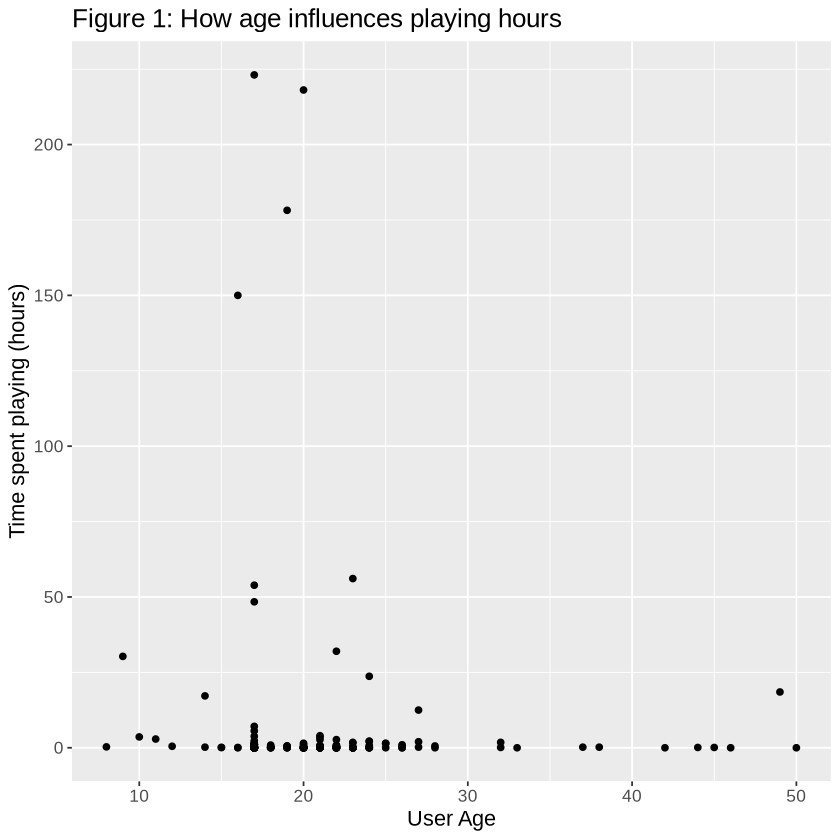

In [3]:
# visualization for exploratory data analysis

options(repr.plot.width = 7, repr.plot.height = 7) 

plot_1 <- player_data |>
          ggplot(aes(x = age, y = played_hours)) +
          geom_point () +
          labs(x = "User Age", y = "Time spent playing (hours)") +
          ggtitle("Figure 1: How age influences playing hours") +
 theme(text = element_text(size = 13))

plot_1

This scatter plot very loosely shows that ages ranging between 16-22 may have higher playing hours. These are the only ages where there are outliers with very high playing hours (150hrs+). However much of the data doesn't report playing hours for many of the ages, meaning the relationship is unable to be confirmed.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


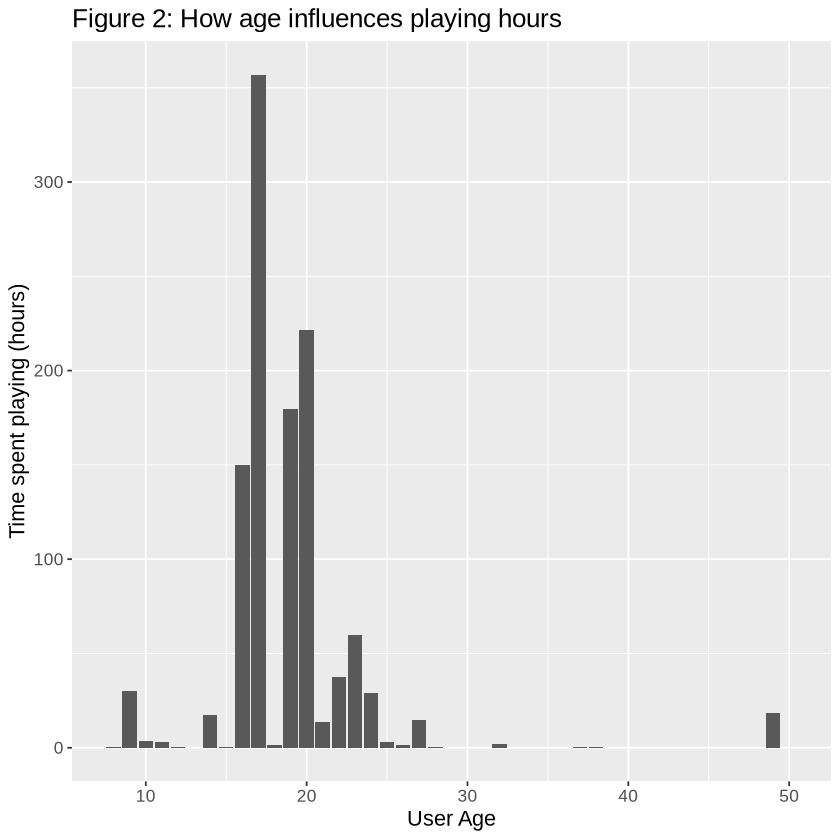

In [4]:
options(repr.plot.width = 7, repr.plot.height = 7) 

plot_2 <- player_data |>
        ggplot(aes(x = age, y = played_hours)) +
        geom_bar(stat = "identity") +
        labs(x = "User Age", y = "Time spent playing (hours)") +
        ggtitle("Figure 2: How age influences playing hours") +      
theme(text = element_text(size = 13))

plot_2  

From this bar plot, we can clearly see that the ages with the highest playing hours fall between 15-20 years of age. This basic visualization already provides valuable insight into the potential relationship between the two variables by showing that 
younger people spend more time playing.

In [5]:
# analysis code starting here
# data wrangling to remove NAs from the data
set.seed(3000)
player_data <- player_data |>
                filter(age != "NA")

In [6]:
# splitting the data in a training and testing set
set.seed(3000)
player_split <- initial_split(player_data, prop = 0.75, strata = played_hours)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [7]:
# setting up the kknn model
set.seed(3000)
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

In [8]:
# setting up the recipe
set.seed(3000)
player_recipe <- recipe(played_hours ~ age, data = player_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

In [9]:
# creating the vfold and workflow to begin looking for the best k value to use
set.seed(3000)
player_vfold <- vfold_cv(player_training, v = 5, strata = played_hours)

player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)

In [10]:
# getting the metrics to see which k values have the best rmse
set.seed(3000)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_results <- player_workflow |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()

In [11]:
# filtering for the best k value
set.seed(3000)
player_min <- player_results |>
   filter(.metric == 'rmse') |>
   slice_min(mean)

player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,rmse,standard,22.85297,5,7.749875,Preprocessor1_Model06


In [12]:
# using the best k value to make the best model and workflow
set.seed(3000)
k_min <- player_min |>
         pull(neighbors)

player_best_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_min) |>
         set_engine('kknn') |>
         set_mode('regression')

player_best_fit <- workflow() |>
         add_recipe(player_recipe) |>
         add_model(player_best_spec) |>
         fit(data = player_training)

In [13]:
# getting the summary results of the best model to use for prediction and vizualization
set.seed(3000)
player_summary <- player_best_fit |>
          predict(player_testing) |>
          bind_cols(player_testing) |>
          metrics(truth = played_hours, estimate = .pred)

player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,32.74735952
rsq,standard,0.01441774
mae,standard,9.28956044


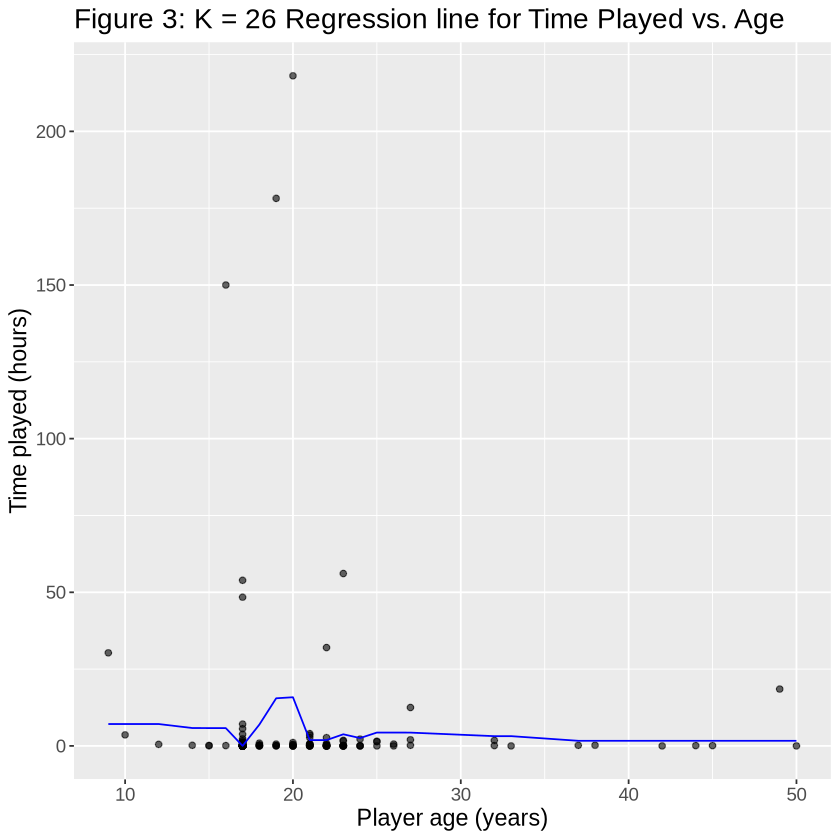

In [17]:
# creating the vizualization of the best k value regression line
set.seed(3000)
options(repr.plot.width = 7, repr.plot.height = 7)

player_preds <- player_best_fit |>
  predict(player_training) |>
  bind_cols(player_training)

player_plot <- ggplot(player_preds, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  geom_line(data = player_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue") +
              xlab("Player age (years)") +
              ylab("Time played (hours)") +
                ggtitle('Figure 3: K = 26 Regression line for Time Played vs. Age') +
 theme(text = element_text(size = 14))

player_plot

## Discussion